# Simulate from Sequential Sampling Models with the `ssms` python package

This is a small tutorial to illustrate how to simulate data from a variety of *Sequential Sampling Models* (SSMs) using the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) python package.
The main simulators in this package are written in [`cython`](https://cython.readthedocs.io/en/latest/), to optimize for speed of computation. 
SSMs take a central role in the joint modeling of reaction times and choice in Cognitive Science.
The [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package is part of the [`hddm`](https://hddm.readthedocs.io/en/latest/) ecosystem to which, amongst others, the [`kabuki`](https://github.com/hddm-devs/kabuki) and [`lanfactory`](https://github.com/AlexanderFengler/LANfactory) python packages belong. 

It takes it's place in this ecosystem, by providing the simulation backend for [`hddm`](https://hddm.readthedocs.io/en/latest/) package.

### Installation Instructions (colab)

*Colab* notebooks usually have quite a few packages preinstalled. It should be sufficient to simply install the `ssms` package.

In [ ]:
# !pip install git+https://github.com/AlexanderFengler/ssm_simulators@main

### Import Modules

In [1]:
import ssms
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

### Basic Package Outline

Let's take a quick look at the structure of the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package by using the help functoin.

In [2]:
help(ssms)

Help on package ssms:

NAME
    ssms

PACKAGE CONTENTS
    basic_simulators (package)
    config (package)
    dataset_generators (package)
    support_utils (package)

VERSION
    0.2.0

FILE
    /users/afengler/data/software/miniconda3/envs/pymc_ak_lan/lib/python3.9/site-packages/ssms/__init__.py




The package consists of **four main submodules**. 

1. The `basic_simulators` submodule, which provides low level access to the model simulators.
2. The `config` submodule provides configuration files for the models included.
3. The `dataset_generators` submodule builds on top of the `basic_simulators` module and supplies a variety of methods for systematically generating data for downstream usecases. This is biased towards generating training data for usage with the [`lanfactory`](https://github.com/AlexanderFengler/LANfactory) package. The [`lanfactory`](https://github.com/AlexanderFengler/LANfactory) package in turn feeds into the [`hddm`](https://hddm.readthedocs.io/en/latest/) package with compatible neural network classes. Learn more about what the goals behind this pipeline are [here](https://elifesciences.org/articles/65074) and [here](https://direct.mit.edu/jocn/article/34/10/1780/112585/Beyond-Drift-Diffusion-Models-Fitting-a-Broad). 
4. The `support_utils` module collect a few convenience functions that may be helpful when using [`ssms`](https://github.com/AlexanderFengler/ssm_simulators).

### Background on the modeling framework

Let's simulate some data from the basic [Diffusion Decision Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2474742/) (DDM).
We can use the `ssms.config.model_config` dictionary to check some information about this model. Importantly we can check the number, name (and order) of parameters under the `'params'` keyword. In this case there are *four parameters*, `['v', 'a', 'z', 't']`.



In [3]:
ssms.config.model_config['ddm']

{'name': 'ddm',
 'params': ['v', 'a', 'z', 't'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]],
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'n_params': 4,
 'default_params': [0.0, 1.0, 0.5, 0.001],
 'hddm_include': ['z'],
 'nchoices': 2}

There is a large literature applying the DDM for the analysis of reaction time and choice data from a large variety of behavioral and/or psychophysics experiments. You can learn more about the interpretation of these parameters e.g. [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2474742/).

Shortly, the Diffusion Decision Model assumes that decision and reactions times derive from boundary crossings of a particle diffusion process. The parameters then have the following interpretations:

1. 'v' is a *deterministic drift* applied to the particle over time (one interpretation is that this describes the *rate of evidence accumulation* over time). 
2. 'a' is the *height of the boundary* to be crossed (crossing the upper or lower boundary respectively describe unique choices).
3. 'z' is the *starting point* of the particle (which may be biased towards either boundary, in turn representing choice options).
4. 't' accounts for the part of a final reaction *time captured by all processes unrelated to the actual processing of the decision-relevant evidence*. It simply shifts the final decision time. 

The picture below illustrates. Note, the upper and lower black histograms describe the reaction time distributions for the upper and lower choice respectively.

<p align="center" width="100%">
    <img width="40%" src=ddm_process.png>
</p>

### Let's simulate

In [4]:
from ssms.basic_simulators import simulator

Using the `simulator()` function we can pick our model of choice (`model` argument), supply a vector (or matrix for a trial-wise logic on parameter values) of parameters and set a number of `n_samples` we want to draw from our DDM process. The `delta_t` arguments controls how fine-grained the time-steps of our simulator are. Interpret $0.001$ as timesteps of $1ms$. Making the time-steps coarser, will speed up the simulation however reduce the accuracy with which the underlying diffusion process is represented by the simulations. 

`ssms` uses the basic [Euler Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) to forward simulate the diffusion trajectories (particle trajectories).

In [5]:
simulations = simulator(model = 'ddm',
                        theta = [1., 1.5, 0.5, 0.5],
                        n_samples = 1000,
                        delta_t = 0.001,
                        random_state = 42)

The output of the simulator function is python `dictionary`, with *three keys*. 

1. `rts` storing the simulated reaction times. Values are positive real numbers. 
2. `choices` storing the respective choices. Values are `-1`, `1` respectively for lower and upper boundary crossings.
3. `metadata` stores information about the simulator configurations and more.

In [6]:
simulations.keys()

dict_keys(['rts', 'choices', 'metadata'])

A simple way to plot the resulting simulator runs is to put negative choices (the lower bound was crossed) on the negative real numbers, and positive choices on the positive real numbers, then using a simple histogram to illustrate the total (choice, reaction-time) - distribution.

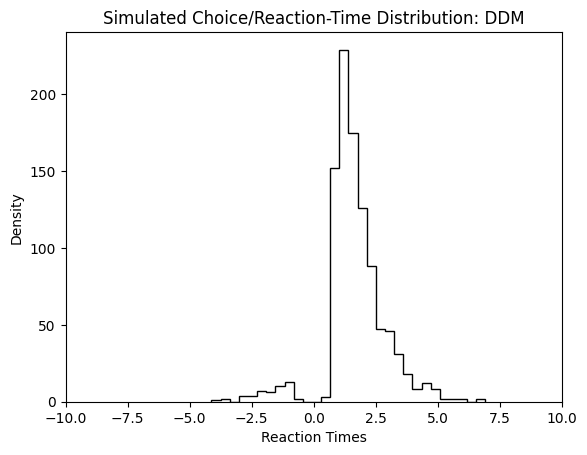

In [7]:
plt.hist(simulations['rts'] * simulations['choices'], 
         bins = 30, 
         histtype = 'step', 
         color = 'black')
plt.xlim(-10, 10)
plt.xlabel("Reaction Times")
plt.ylabel("Density")
plt.title("Simulated Choice/Reaction-Time Distribution: DDM")
plt.show()

### Changing the Model

Instead we might be interested in simulating from a model of the following form.

![Angle pic](angle_process.png)

We can check the properties of this model via the `ssms.config.model_config` dictionary again. This time under the `angle`, `key`. 

In [8]:
ssms.config.model_config['angle']

{'name': 'angle',
 'params': ['v', 'a', 'z', 't', 'theta'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1], [3.0, 3.0, 0.9, 2.0, 1.3]],
 'boundary': <function ssms.basic_simulators.boundary_functions.angle(t=1, theta=1)>,
 'n_params': 5,
 'default_params': [0.0, 1.0, 0.5, 0.001, 0.0],
 'hddm_include': ['z', 'theta'],
 'nchoices': 2}

The parameters are equivalent to the DDM models', however the `theta` parameter is added, which specifies the *angle of the boundaries*.

In [9]:
simulations_angle = simulator(model = 'angle',
                        theta = [1., 1.5, 0.5, 0.5, 0.3],
                        n_samples = 1000,
                        delta_t = 0.001,
                        random_state = 42)

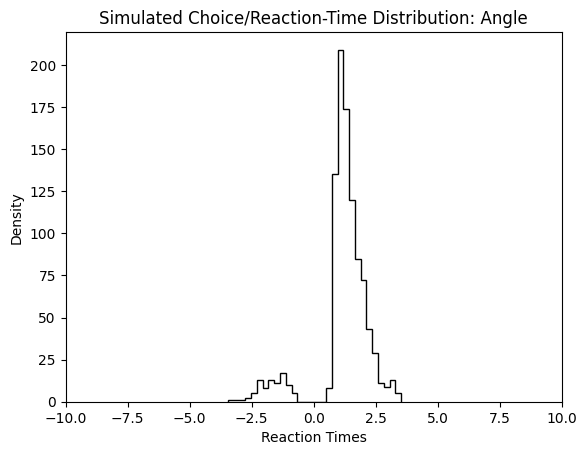

In [10]:
plt.hist(simulations_angle['rts'] * simulations_angle['choices'], 
         bins = 30, 
         histtype = 'step', 
         color = 'black')
plt.xlim(-10, 10)
plt.xlabel("Reaction Times")
plt.ylabel("Density")
plt.title("Simulated Choice/Reaction-Time Distribution: Angle")
plt.show()

We can change to value of the `theta` parameter, and observe how the simulated reaction times change in response. 

In [13]:
simulations_angle = simulator(model = 'angle',
                        theta = [1., 1.5, 0.5, 0.5, 0.7],
                        n_samples = 1000,
                        delta_t = 0.001,
                        random_state = 42)

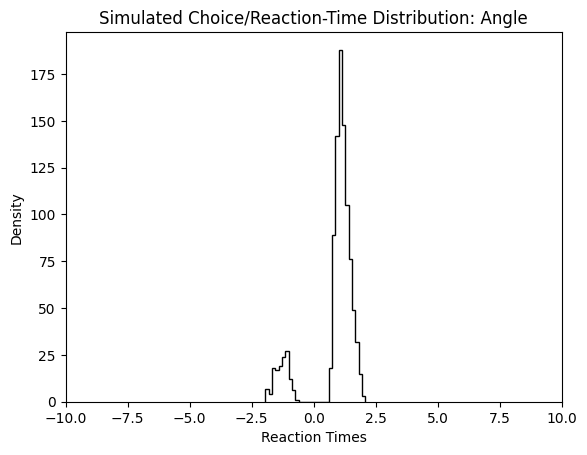

In [14]:
plt.hist(simulations_angle['rts'] * simulations_angle['choices'], 
         bins = 30, 
         histtype = 'step', 
         color = 'black')
plt.xlim(-10, 10)
plt.xlabel("Reaction Times")
plt.ylabel("Density")
plt.title("Simulated Choice/Reaction-Time Distribution: Angle")
plt.show()

### How to investigate the ready-to-use models

`ssms` comes with a large variety of such model variations predefined. As mentioned above, you can learn about them by inspecting the `model_config` dictionary.
Few basic principles may help you navigate the space of the models. Take another example, the model corresponding to the `"weibull"`, `key`.

In [15]:
ssms.config.model_config['weibull']

{'name': 'weibull',
 'params': ['v', 'a', 'z', 't', 'alpha', 'beta'],
 'param_bounds': [[-2.5, 0.3, 0.2, 0.001, 0.31, 0.31],
  [2.5, 2.5, 0.8, 2.0, 4.99, 6.99]],
 'boundary': <function ssms.basic_simulators.boundary_functions.weibull_cdf(t=1, alpha=1, beta=1)>,
 'n_params': 6,
 'default_params': [0.0, 1.0, 0.5, 0.001, 3.0, 3.0],
 'hddm_include': ['z', 'alpha', 'beta'],
 'nchoices': 2}

To understand the properties of this model look for the following attributes. 

1. The `v`, `a`, `z`, `t` parameters have essentially equivalent interpretations across the board (see above). 
2. The `boundary` is either `None` or a `function`, which is vectorized along the `t` input (for time). The argument names to the function correspond to the names in the `params`, `key`. Here, the `alpha` and `beta` arguments refer to boundary parameters.
3. The `nchoices`, `key` contains the number of choice options that a given model allows. To interpret model behavior, there are essentially two kinds of settings. Either `nchoices` is set to `2`, in which case the model can be interpreted as simulating a *single particle* which moves between two (upper and lower) boundaries. If `nchoices > 2`, then we should interpret the model as have as many moving particles, which cross a single *upper* bound.

Let's take a look at the *boundary* of the `"weibull"` model.

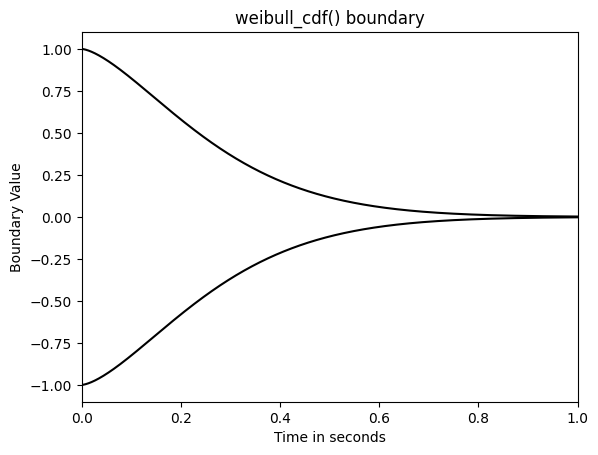

In [16]:
from ssms.basic_simulators.boundary_functions import weibull_cdf

plt.plot(np.linspace(0, 1, 1000), 
         weibull_cdf(t = np.linspace(0, 10, 1000), alpha = 1.5, beta = 3),
         color = 'black')
plt.plot(np.linspace(0, 1, 1000), 
         -weibull_cdf(t = np.linspace(0, 10, 1000), alpha = 1.5, beta = 3),
         color = 'black')
plt.ylim(-1.1, 1.1)
plt.xlim(0, 1)
plt.title("weibull_cdf() boundary")
plt.xlabel("Time in seconds")
plt.ylabel("Boundary Value")
plt.show()

There are *two styles* or boundaries: `multiplicative` and `additive`. 

If the boundary function automatically gives you boundary values between $0$ and $1$, then the boundary will be `multiplicative`, meaning that the `a` parameters will be multiplied by the boundary shape to get the final boundary applied in the simulator. Else, `a` will be added to the boundary returned by the given bounadry function. 

Hence, the `weibull_cdf()` boundary is `multiplicative`. 

In contrast consider the `angle()` boundary.



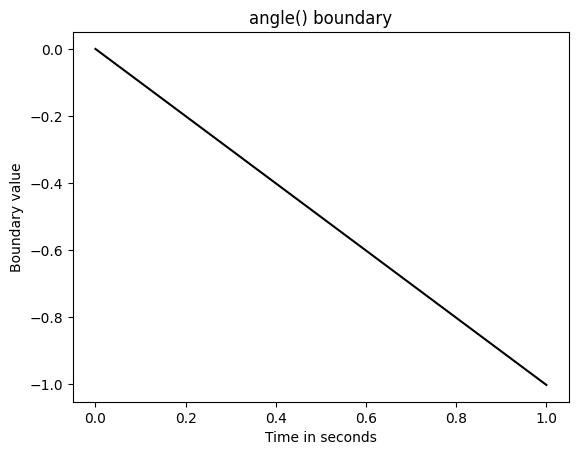

In [17]:
from ssms.basic_simulators.boundary_functions import angle

plt.plot(np.linspace(0, 1, 1000), 
         angle(t = np.linspace(0, 10, 1000), theta = 0.1),
         color = 'black')
plt.title("angle() boundary")
plt.xlabel("Time in seconds")
plt.ylabel("Boundary value")
plt.show()

### Timings

In [18]:
from time import time
n_samples = 1000
time_start = time()
for i in range(10):
    simulations_angle = simulator(model = 'ddm',
                                  theta = [1., 1.5, 0.5, 0.5],
                                  n_samples = n_samples,
                                  delta_t = 0.001,
                                  random_state = 42)
time_end = time()
               
print('The simulator ran an average of ', round((time_end - time_start) / 10, 2), 'seconds \nto produce', n_samples, 'sample trajectories from the DDM!') 

The simulator ran an average of  0.09 seconds 
to produce 1000 sample trajectories from the DDM!


### End

Stay tuned for a sequence of blog posts, which will close the gap (via the [`lanfactory`](https://github.com/AlexanderFengler/LANfactory) package) towards using the [`hddm`](https://hddm.readthedocs.io/en/latest/) and finally the [`pymc`](https://www.pymc.io/welcome.html) python package for purposes of hierarchical bayesian modeling (inference) with such SSMs.

We will learn more about [`ssms`](https://github.com/AlexanderFengler/ssm_simulators), specifically how to leverage the package to generate training data for [`jax`](https://github.com/google/jax) (with the help of the [`flax`](https://flax.readthedocs.io/en/latest/) and [`optax`](https://optax.readthedocs.io/en/latest/) packages) and [`pytorch`](https://pytorch.org/) networks. We will then consider training such networks conveniently with the [`lanfactory`](https://github.com/AlexanderFengler/LANfactory) package. 

Such neural networks can then be used as likelihood functions for bayesian inference with [`hddm`](https://hddm.readthedocs.io/en/latest/) and/or [`pymc`](https://www.pymc.io/welcome.html), following [recent research](https://elifesciences.org/articles/65074) in computational cognitive science. We will motivate why one may be interested in this approach to inference.